Generally, a parameter selection procedure might be necessary to evaluate Probability of
Detection versus Probability of False Alarm (i.e., Pd versus Pf) in order to select a classifier
model and/or select a value for a hyperparameter for a classifier.

In this assignment we will produce an ROC plot presenting operating points of various
classifiers and their varying hyperparameters so that we can make a justifiable operating
classifier/parameter selection for the following problem.

The classification of fake news or misinformation is a very important task today. Download the
disinformation/fake news dataset from the module, containing Fake.csv and True.csv files.
Load the datasets into your model development framework and examine the features to
confirm that they are text in title and text columns. Set fake as 1 and true as 0.
Concatenate the datasets together to produce one dataset of around 44,880 rows. Apply
necessary pre-processing to extract the title column with Tf-Idf. (This assigns numerical
values to terms based on their frequency in a given document and throughout a given
collection of documents.) Use around 50 features. Make sure to include a sanity check in the
pipeline and perhaps run your favorite baseline classifier first.

<pre>
```python
df_true['class'] = 0; df_fake['class'] = 1
df = pd.concat([df_fake, df_true])
X = TfidfVectorizer(stop_words='english',
max_features=40).fit_transform(df['title'])
```
</pre>

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Locate and load the data files
df_fake = pd.read_csv('../../Desktop/APML/Datasets/disinformation/disinformation_Fake.csv')
df_true = pd.read_csv('../../Desktop/APML/Datasets/disinformation/disinformation_True.csv')

# Assign class labels
df_true['class'] = 0; df_fake['class'] = 1
# Concatenate the datasets
df = pd.concat([df_fake, df_true], ignore_index=True)
# Check final dataset
df.info()

# Checking for duplicates - adapted from Guven, 2024.
df["is_duplicate"]= df.duplicated()
print(f"#duplicated= {len(df[df['is_duplicate']==True])}")

# Drop the duplicate rows using index - best way to drop in pandas
index_to_drop = df[df['is_duplicate']==True].index
df.drop(index_to_drop, inplace=True)

# Remove the duplicate marker column
df.drop(columns='is_duplicate', inplace=True)
print(f'#total= {len(df)}')

# # Check unique levels and see any marker is used for a missing level
# for col in df.columns:
#     if df[col].dtype == object:
#         print(col, df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
#duplicated= 209
#total= 44689


In [86]:
# Text pre-processing and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

X = TfidfVectorizer(stop_words='english', max_features=50).fit_transform(df['title'])
y = df['class']

In [87]:
# Sanity check for pre-processing pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier, eg. logistic regression 
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Print a classification report to check performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82      4200
           1       0.93      0.69      0.79      4738

    accuracy                           0.81      8938
   macro avg       0.83      0.82      0.81      8938
weighted avg       0.83      0.81      0.81      8938



**1.** [70 pts] By using three classifiers—decision tree, random forest, and neural network—and
at least 2 different hyperparameter settings for each, generate operating points and plot
them on a ROC. In particular, plot mean TPR and mean FPR, where the means are taken
from the multiple runs of cross-validations. Do not hesitate to use/modify the ROC plot code
in the module notebook if necessary. In case you do not see enough variety in Pd-Pf you
might need to work on the classifiers set and/or hyperparameters. And do not hesitate to try
hundreds, if necessary, since the ROC is just a natural scatter plot.

(Some recommended parameters and ranges: depth [3-12], number of features [3-20],
number of estimators [20-100], layer size [1-10], learning rate; and total of 10-20 Ops.)

**Ans.**

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix,  roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.sparse import vstack

# Define cross-validation
cv = StratifiedKFold(n_splits=5)

# Placeholder for mean TPRs and FPRs
mean_fpr = np.linspace(0, 1, 100)

# Define classifiers
# Decision Trees
dt_classifiers = [
    (DecisionTreeClassifier(max_depth=depth, max_features=features), f"Decision Tree depth={depth}, features={features}")
    for depth in range(3, 13, 3)  # Exploring depths from 3 to 12 in steps of 3
    for features in range(3, 21, 6)  # Exploring feature counts from 3 to 20 in steps of 6
]

# Random Forests
rf_classifiers = [
    (RandomForestClassifier(n_estimators=n_estimators, max_features=features, random_state = 42), f"Random Forest estimators={n_estimators}, features={features}")
    for n_estimators in range(20, 101, 40)  # Exploring estimators from 20 to 100 in steps of 40
    for features in range(3, 21, 6)  # Exploring feature counts from 3 to 20 in steps of 6
]

# Neural Networks
nn_classifiers = [
    (make_pipeline(StandardScaler(with_mean=False), 
                   MLPClassifier(hidden_layer_sizes=(size,)*layers, learning_rate_init=lr, max_iter=1000)),
     f"NN layers={layers}, size={size}, lr={lr}")
    for layers in range(1, 3)  # Exploring 1 to 2 hidden layers
    for size in [10, 50, 100]  # Exploring layer sizes of 10, 50, 100
    for lr in [0.001, 0.01]  # Exploring learning rates of 0.001 and 0.01
]

# Combine all classifiers
classifiers = dt_classifiers + rf_classifiers + nn_classifiers

In [89]:
def compute_roc_metrics(X, y, classifiers, cv):
    # Initialize storage for metrics
    classifier_metrics = []

    # Compute metrics
    for clf, label in classifiers:
        all_tprs = []
        all_fprs = np.linspace(0, 1, 100)
        all_aucs = []

        for train, test in cv.split(X, y):
            X_train_fold, y_train_fold = X[train], y.iloc[train]
            X_test_fold, y_test_fold = X[test], y.iloc[test]

            clf.fit(X_train_fold, y_train_fold)

            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_test_fold)[:, 1]
            else:  # Use decision function for classifiers without predict_proba
                y_proba = clf.decision_function(X_test_fold)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

            fpr, tpr, thresholds = roc_curve(y_test_fold, y_proba)
            roc_auc = auc(fpr, tpr)
            all_aucs.append(roc_auc)

            interp_tpr = np.interp(all_fprs, fpr, tpr)
            interp_tpr[0] = 0.0
            all_tprs.append(interp_tpr)

        mean_tpr = np.mean(all_tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(all_fprs, mean_tpr)
        std_auc = np.std(all_aucs)

        classifier_metrics.append({
            'label': label,
            'fpr': all_fprs,
            'tpr': mean_tpr,
            'auc': mean_auc,
            'std_auc': std_auc
        })
    
    return classifier_metrics

classifier_metrics = compute_roc_metrics(X, y, classifiers, cv)

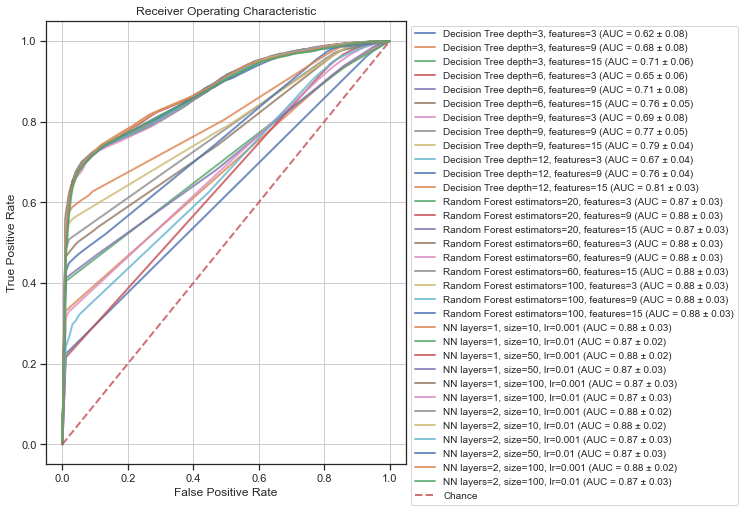

In [90]:
# Plotting function
def plot_roc_curves(classifier_metrics):
    plt.figure(figsize=(8, 8))

    for metrics in classifier_metrics:
        label = metrics['label']
        fpr = metrics['fpr']
        tpr = metrics['tpr']
        auc = metrics['auc']
        std_auc = metrics['std_auc']
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {auc:.2f} ± {std_auc:.2f})', alpha=.8)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='upper left',  bbox_to_anchor=(1, 1), fontsize='small')  
    plt.subplots_adjust(right=0.75)  # Adjust subplot params to make room for the legend
    plt.grid()
    plt.show()
    
# Call the plotting function with the results
plot_roc_curves(classifier_metrics)

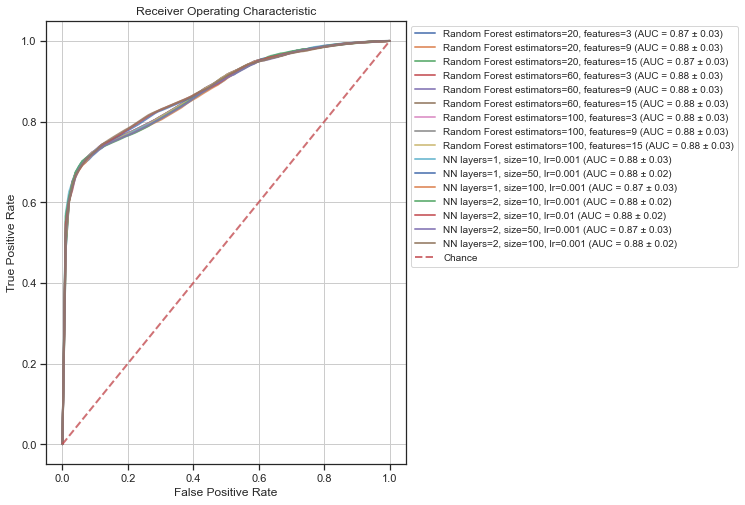

In [91]:
# Basic analysis - sorting based on AUC to filter the worst-performing classifiers
def filter_classifiers_by_median_auc(classifier_metrics):
    # Calculate the median AUC
    auc_values = [metrics['auc'] for metrics in classifier_metrics]
    median_auc = np.median(auc_values)

    # Filter classifiers with AUC greater than the median AUC
    filtered_classifiers = [metrics for metrics in classifier_metrics if metrics['auc'] > median_auc]
    return filtered_classifiers

# Call the plotting function with the filtered results
filtered_classifier_metrics = filter_classifiers_by_median_auc(classifier_metrics)
plot_roc_curves(filtered_classifier_metrics)

2. [10 pts] What kind of behavior would you expect to see in Pd - Pf interaction of an ROC
plot? Do you see it in yours? (Hint: Pd and Pf correspond to TPR and FPR.)

**Ans.** In an ROC plot, as the threshold for classifying positive instances varies, you expect to see a trade-off between the Probability of Detection (Pd, or TPR) and the Probability of False Alarm (Pf, or FPR). Typically, an  effective classifier curve starts at the bottom left corner (0,0) and moves towards the top left corner (0,1), indicating an increase in TPR with minimal increase in FPR. The closer the curve is to the top left corner, the better the classifier's performance. A curve below the diagonal line indicates worse-than-random performance. The same trend is seen in the generated plot.

3. [10 pts] From the ROC plot that you created make a selection of the classifier and
hyperparameter setting for this problem and then justify the selection. Note that we are
classifying fake news so your conclusion might be subjective but has to be supported by
your findings.

**Ans.** Based on these criteria, it's better to select a classifier that shows both a high mean AUC and low standard deviation, representing a balance between good performance and reliability. For fake news detection, depending on the application, we might prefer to err on the side of falsely flagging true news as fake (higher FPR) rather than letting fake news be classified as true (lower TPR). This is because the cost of not detecting fake news might be higher than the inconvenience caused by additional verification of true news flagged as fake. Random Forest with 100 estimators and 15 features and Neural Network (NN) models with various layers and sizes have similar AUC values around 0.88. I would choose a Random Forest with estimators = 20 and features = 15 to strike a balance between performance and number of features for more complex data. Random forest is chosen over NNs due to its more interpretability and less computationally expensive. On the other hand, if you prioritize scalability, flexibility, and the ability to capture complex patterns in large datasets, NN with layers = 1, size = 10 and lr = 0.01 would be a good alternative.

4. [10 pts] Try adding text column to the features (again with Tf-Idf). Choose any classifier
model to train on this new and improved dataset and report on its performance. Why do
you think the performance is much higher than the previous one which only uses title
column?

**Ans.** Decision tree used is for comparison.

In [92]:
from scipy.sparse import hstack  # To horizontally stack sparse matrices
from sklearn.metrics import accuracy_score

title_features = X
text_vectorizer = TfidfVectorizer(stop_words='english', max_features=50) 
text_features = text_vectorizer.fit_transform(df['text'])

X_title = title_features
# Combine features from 'title' and 'text'
X_title_text = hstack([title_features, text_features])
y = df['class'] 


X_train, X_test, y_train, y_test = train_test_split(X_title_text, y, test_size=0.2, random_state=42)

classifier = DecisionTreeClassifier(max_depth= 20, max_features = 3)
classifier.fit(X_train, y_train)

# Step 4: Performance Evaluation
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      4200
           1       0.92      0.79      0.85      4738

    accuracy                           0.85      8938
   macro avg       0.86      0.85      0.85      8938
weighted avg       0.86      0.85      0.85      8938

Accuracy: 0.8500783172969344


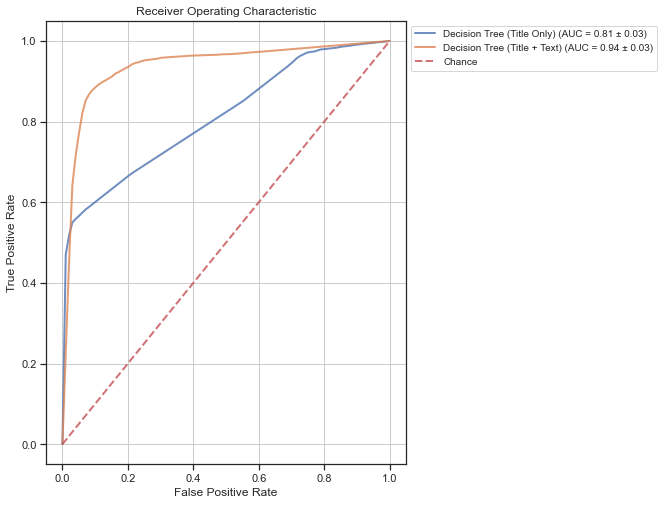

In [93]:
classifiers_title = [
    (DecisionTreeClassifier(max_depth= 20, max_features = 3), 'Decision Tree (Title Only)')
]

classifiers_title_text = [
    (DecisionTreeClassifier(max_depth= 20, max_features = 3), 'Decision Tree (Title + Text)')
]

# Compute ROC metrics for classifiers using title features only
classifier_metrics_title = compute_roc_metrics(X_title, y, classifiers_title, cv)

# Compute ROC metrics for classifiers using combined title and text features
classifier_metrics_title_text = compute_roc_metrics(X_title_text, y, classifiers_title_text, cv)

# Combine metrics from both feature sets for plotting
all_classifier_metrics = classifier_metrics_title + classifier_metrics_title_text

# Call the plotting function with combined metrics
plot_roc_curves(all_classifier_metrics)


Using both the `title` and `text` columns for feature extraction likely leads to higher performance due to several reasons:

1. **More Information**: The `text` column contains the body of the news articles, which provides much more context and information than the `title` alone. This additional context can help the classifier make more informed decisions, especially in cases where the title might be ambiguous or not fully indicative of the article's content.

2. **Richer Vocabulary**: The body text likely includes a wider range of vocabulary and expressions related to fake and real news, offering more features for the classifier to learn from.

3. **Contextual Nuances**: The `text` column can contain narrative styles, claims, and evidences that are more detailed and nuanced, which can be crucial in distinguishing between fake and real news.